ore_de_studiu -> variabila independenta conform cerintei
promovare -> variabila dependenta conform cerintei

In [5]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as st

ore_de_studiu = np.array([1, 3, 4, 5, 6, 8])
promovare = np.array([0, 0, 1, 1, 1, 1])


Definim o distributie prior normala pentru intercept (alpha) cu medie 0 si abatere standard 10. Acest prior este slab informativ, fara a constrange valorile si lasand datele sa vorbeasca. Asemenea pentru beta.

invlogit este functia logistica inversa care transforma alpha + beta ori x in valori intre 0 si 1 reprezentand probabilitati
p este un vector de probabilitati cu cate o valorare pentru fiecare observatie din ore_de_studiu
Definim distributia Bernoulli pentru verosimilitatea datelor binare observate

In [6]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    p = pm.Deterministic('p', pm.math.invlogit(alpha + beta * ore_de_studiu))
    y_obs = pm.Bernoulli('y_obs', p, observed=promovare)
    trace = pm.sample(draws=3000, tune=2000, chains=2, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 33 seconds.
There were 462 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Extragem valorile a posteriori pentru alpha si beta
Frontiera de decizie se gaseste unde probabilitatea de promovare este de 0.5
Calculam intervalul HDI pentru frontiera de decizie cu un nivel de credibilitate de 94%

In [7]:
alpha_post = trace.posterior['alpha'].values.flatten()
beta_post = trace.posterior['beta'].values.flatten()

# x_decizie = -alpha / beta
x_decizie_post = -alpha_post / beta_post
hdi_bounds = az.hdi(x_decizie_post, hdi_prob=0.94)

Generarea graficului

C:\Users\ddanc\AppData\Local\Temp\ipykernel_20300\2584715105.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  p_hdi = az.hdi(p_samples, hdi_prob=0.94)  # HDI pe curba


Rezumat posterior pentru alpha:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -11.527  5.994 -22.985   -1.511      0.213    0.156     785.0     908.0   

       r_hat  
alpha    1.0  
Rezumat posterior pentru beta:
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta  3.48  1.685   0.615    6.641      0.059    0.043     777.0     821.0   

      r_hat  
beta    1.0  

Frontiera de decizie (x_decizie = -alpha/beta):
Media posterior: 3.3044602636079072
Interval HDI 94% pentru frontiera de decizie: [1.91460571 4.68146886]


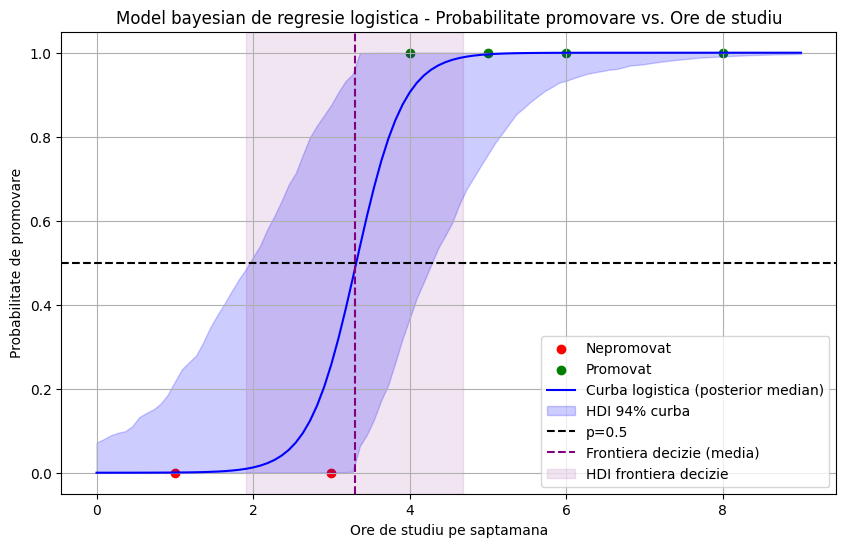

In [8]:
# Pentru a desena curba, extragem o grila de valori ale orelor de studiu
x_grid = np.linspace(min(ore_de_studiu)-1, max(ore_de_studiu)+1, 100)

# Calculam probabilitatile pentru curba mediana a posteriorului
# Folosim medianele sau mediile posteriorului
alpha_median = np.median(alpha_post)
beta_median = np.median(beta_post)
p_median = 1/(1+np.exp(-(alpha_median + beta_median*x_grid)))

# Pentru intervalele de credibilitate ale curbei, putem calcula p pentru toate mostrele si apoi HDI
p_samples = []
for a, b in zip(alpha_post[:1000], beta_post[:1000]):  # luam un subset pentru rapiditate
    p_samples.append(1/(1+np.exp(-(a + b*x_grid))))
p_samples = np.array(p_samples)
p_hdi = az.hdi(p_samples, hdi_prob=0.94)  # HDI pe curba

print("Rezumat posterior pentru alpha:")
print(az.summary(trace, var_names=["alpha"]))
print("Rezumat posterior pentru beta:")
print(az.summary(trace, var_names=["beta"]))
print("\nFrontiera de decizie (x_decizie = -alpha/beta):")
print("Media posterior:", np.mean(x_decizie_post))
print("Interval HDI 94% pentru frontiera de decizie:", hdi_bounds)

plt.figure(figsize=(10,6))

plt.scatter(ore_de_studiu[promovare==0], promovare[promovare==0], color='red', label='Nepromovat')
plt.scatter(ore_de_studiu[promovare==1], promovare[promovare==1], color='green', label='Promovat')
plt.plot(x_grid, p_median, color='blue', label='Curba logistica (posterior median)')
plt.fill_between(x_grid, p_hdi[:,0], p_hdi[:,1], color='blue', alpha=0.2, label='HDI 94% curba')
plt.axhline(0.5, color='black', linestyle='--', label='p=0.5')

# Intervalul HDI pentru frontiera de decizie
# Afisam linia verticala la media frontierei si zona HDI
frontiera_mediu = np.mean(x_decizie_post)
plt.axvline(frontiera_mediu, color='purple', linestyle='--', label='Frontiera decizie (media)')
plt.axvspan(hdi_bounds[0], hdi_bounds[1], color='purple', alpha=0.1, label='HDI frontiera decizie')

plt.title("Model bayesian de regresie logistica - Probabilitate promovare vs. Ore de studiu")
plt.xlabel("Ore de studiu pe saptamana")
plt.ylabel("Probabilitate de promovare")
plt.legend()
plt.grid(True)
plt.show()
